In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Fix the seed:
np.random.seed(13)

## Autoregressive Model

In [3]:
def get_trajectory(trajectory_length, a, b, sigma, gamma):
    """
    Generate a single trajectory of length 2*trajectory_length from a linear trend autoregressive process.
    The first half will be for training, the second half for validation.
    
    Parameters:
    -----------
    trajectory_length : int
        Length of each half of the trajectory (train and validation)
    a : float
        Slope parameter of the linear trend
    b : float
        Intercept parameter of the linear trend
    sigma : float
        Standard deviation of the noise
    gamma : float
        Autoregressive coefficient
    
    Returns:
    --------
    train_data : np.array
        Training trajectory of shape (trajectory_length,)
    val_data : np.array
        Validation trajectory of shape (trajectory_length,)
    """
    # Calculate stationary standard deviation for initial point
    sigma_stationary = sigma / np.sqrt(1 - gamma**2)
    
    # Generate a trajectory of length 2*trajectory_length
    total_length = 2 * trajectory_length
    trajectory = np.zeros(total_length)
    
    # Generate mean trajectory
    y_mean = np.array([a*i + b for i in range(total_length)])
    
    # Generate initial point y[0]
    epsilon_0 = np.random.randn(1) * sigma_stationary
    trajectory[0] = b + epsilon_0.item()
    
    # Generate subsequent points
    for i in range(1, total_length):
        epsilon = np.random.randn(1) * sigma
        trajectory[i] = (gamma * (trajectory[i-1] - y_mean[i-1]) + y_mean[i] + epsilon).item()
    
    # Split into training and validation
    train_data = trajectory[:trajectory_length]
    val_data = trajectory[trajectory_length:]
    
    return train_data, val_data

class AutoregressiveModel:
    """
    Linear autoregressive model AR(k) with regularization.
    """
    def __init__(self, coefficients, intercept, sigma):
        """
        Initialize the model with fitted coefficients and intercept.
        
        Parameters:
        -----------
        coefficients : np.ndarray
            AR coefficients of shape (k,)
        intercept : float
            Intercept term
        """
        self.coefficients = coefficients
        self.intercept = intercept
        self.sigma = sigma
        self.k = len(coefficients)
    
    def sample(self, initial, n, n_steps):
        """
        Sample future trajectories given initial values.
        
        Parameters:
        -----------
        initial : np.ndarray
            Initial values of shape (k,) where k is the AR order
        n : int
            Number of trajectories to sample (batch size)
        n_steps : int
            Number of steps to predict ahead
            
        Returns:
        --------
        np.array
            Sampled trajectories of shape (n, n_steps)
        """
        if len(initial) < self.k:
            raise ValueError(f"Initial sequence must have at least {self.k} elements")
        
        # Use the last p values as the starting point
        initial = initial[-self.k:]
        
        # Initialize the samples tensor
        samples = np.zeros((n, n_steps))
        
        # Initialize history for each batch
        history = np.tile(initial, (n, 1))
        
        # Generate samples
        for t in range(n_steps):
            # Calculate the deterministic part (AR prediction)
            pred = self.intercept + np.sum(self.coefficients * history[:, :self.k], axis=1)
            
            # Add noise
            noise = np.random.normal(0, 1, size=n)
            samples[:, t] = pred + self.sigma*noise
            
            # Update history (shift and add new prediction)
            if self.k > 1:
                history = np.hstack((samples[:, t].reshape(-1, 1), history[:, :-1]))
            else:
                history = samples[:, t].reshape(-1, 1)
        
        return samples
    
    def predict_time_of_first_crossing(self, initial, n, n_steps, threshold):
        """
        Predict the expected time of first crossing of a threshold.
        
        Parameters:
        -----------
        initial : np.ndarray
            Initial values of shape (k,)
        n : int
            Number of Monte Carlo simulations
        n_steps : int
            Maximum number of steps to look ahead
        threshold : float
            Threshold value to cross
            
        Returns:
        --------
        float
            Expected time of first crossing
        """
        # Sample trajectories
        samples = self.sample(initial, n, n_steps)
        
        # Find first crossing for each trajectory
        crossings = (samples > threshold)
        
        # Get first crossing times (+1 because we're looking at future time steps)
        first_crossing_idx = np.argmax(crossings, axis=1)+1
        
        # Handle cases where no crossing occurs (argmax returns 0 when all elements are 0)
        no_crossing = np.all(samples <= threshold, axis=1)
        first_crossing_idx[no_crossing] = n_steps  # Set to max steps if no crossing
        
        # Calculate mean crossing time (add length of initial sequence)
        mean_crossing_time = np.mean(first_crossing_idx).item()
        
        return mean_crossing_time
    
    def predict_mean_value(self, initial, t):
        """
        Predict the mean value of the process at time t given initial values.
        
        Parameters:
        -----------
        initial : np.ndarray
            Initial sequence of values
        t : int
            Future time step to predict
            
        Returns:
        --------
        float
            Predicted mean value at time t
        """
        if len(initial) < self.k:
            raise ValueError(f"Initial sequence must have at least {self.k} elements")
        
        # Use the last p values
        initial = initial[-self.k:]
        
        # For AR(p) process, we need to iterate through each time step
        # to calculate expected values
        current = initial
        for _ in range(t - len(initial)):
            next_val = self.intercept + np.sum(self.coefficients * current[-self.k:])
            current = np.append(current, next_val)
        
        return float(current[-1])

def fit_autoregressive(train_data, k, weight_decay):
    """
    Fit an AR(p) model to the training data with L2 regularization.
    
    Parameters:
    -----------
    train_data : np.ndarray
        Training data of shape (n,)
    k : int
        Order of the autoregressive model
    weight_decay : float
        L2 regularization strength
        
    Returns:
    --------
    AutoregressiveModel
        Fitted autoregressive model
    """
    # Prepare data: X contains lagged values, y contains target values
    # The last column of X is one's, to represent the intercept
    X = np.ones((len(train_data) - k, k+1))
    for i in range(k):
        X[:, i] = train_data[k-i-1:len(train_data)-i-1]
    
    y = train_data[k:]
    
    # Ridge regression with L2 regularization
    # Formula: β = (X^T X + λI)^(-1) X^T y
    XTX = X.T @ X
    ridge_penalty = weight_decay * np.eye(k+1)
    coefficients_extended = np.linalg.solve(XTX + ridge_penalty, X.T @ y)
    
    # Calculate noise (std of residuals)
    predicted = X @ coefficients_extended
    sigma = np.std(y - predicted)

    # Extract the coefficients and the intercept
    coefficients = coefficients_extended[:-1]
    intercept = coefficients_extended[-1]
    
    return AutoregressiveModel(coefficients, intercept, sigma)

time of first crossing threshold 3: 62
True value at time 199: 4.26588744014857


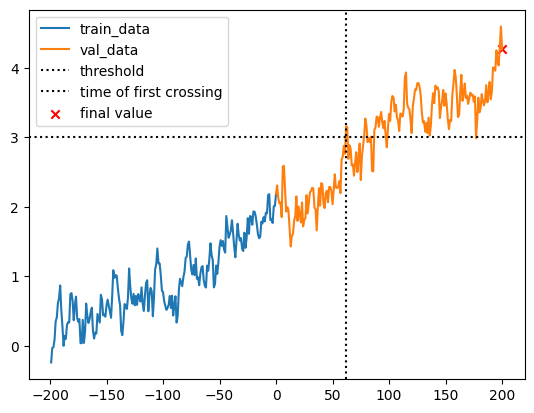

In [4]:
# Generate a trajectory
trajectory_length = 200
a = 0.01  # Slope
b = 0.0   # Intercept
sigma = 0.2  # Noise standard deviation
gamma = 0.8  # Autoregressive coefficient

train_data, val_data = get_trajectory(trajectory_length, a, b, sigma, gamma)
# True time of first crossing for validation data:
threshold = 3
if (val_data <= threshold).all():
    true_first_crossing_time = len(val_data)
else:
    true_first_crossing_time = np.argmax((val_data > threshold)).item()+1
print(f"time of first crossing threshold {threshold}: {true_first_crossing_time}")
# Get true future value:
future_time = len(val_data)-1
true_future_value = float(val_data[future_time])
print(f"True value at time {future_time}: {true_future_value}")

plt.plot(np.arange(-len(train_data)+1, 1), train_data, label="train_data")
plt.plot(np.arange(len(val_data)+1), np.hstack([train_data[-1:], val_data]), label="val_data")
plt.axhline(threshold, color="k", ls=":", label="threshold")
plt.axvline(true_first_crossing_time, color="k", ls=":", label="time of first crossing")
plt.scatter(len(val_data), val_data[-1], label="final value", marker="x", color="red")
plt.legend()

Pictured above is the time-series data we want to model. We want one model to predict both the final value and the time when the series first crosses the threshold. We can use past data (up to time zero) as our training data, while future data (time larger than zero) is our validation data.

We can try to model this data using an $\text{AR}(k)$ process (https://en.wikipedia.org/wiki/Autoregressive_model), but we have two hyperparameters we need to choose: the lag $k$, and the `weight_decay`.

In the cell below, we train and evaluate a number of models.

In [5]:

def evaluate_performance(predicted_first_crossing, predicted_final_value, true_first_crossing, true_final_value):
    # Compute the error of both:
    crossing_error = abs(predicted_first_crossing-true_first_crossing)
    final_error = abs(predicted_final_value-true_final_value)
    return {"crossing_error": crossing_error, "final_error": final_error}

def fit_and_evaluate_model(k, weight_decay, threshold, future_time, verbose=False):
    # Fit an AR(k) model with regularization
    ar_model = fit_autoregressive(train_data, k, weight_decay)
    
    # Sample future trajectories
    initial_seq = train_data[-k:]
    num_samples = 100
    forecast_horizon = len(val_data)
    samples = ar_model.sample(initial_seq, num_samples, forecast_horizon)
    
    # Predict time of first crossing
    crossing_time = ar_model.predict_time_of_first_crossing(initial_seq, num_samples, forecast_horizon, threshold)
    
    # Predict mean value at a future time
    mean_value = ar_model.predict_mean_value(initial_seq, future_time)
    if verbose:
        plt.plot(np.arange(-len(train_data)+1, 1), train_data, label="train_data")
        plt.plot(np.arange(len(val_data)+1), np.hstack([train_data[-1:], val_data]), label="val_data")
        plt.axhline(threshold, color="k", ls=":", label="threshold")
        plt.axvline(true_first_crossing_time, color="k", ls=":", label="time of first crossing")
        plt.scatter(len(val_data), val_data[-1], label="final value", marker="x", color="k")
        
        # Plot the samples:
        for i in range(5):
            plt.plot(np.arange(len(val_data)+1), np.hstack([train_data[-1:], samples[i]]), color="green", ls=":", lw=".2")
        
        plt.axvline(crossing_time, color="red", ls=":", label="predicted time of first crossing")
        plt.scatter(len(val_data), mean_value, label="predicted final value", marker="x", color="red")

        
        plt.legend()
        
        print(f"Expected time of first crossing threshold {threshold}: {crossing_time}")
        print(f"Predicted mean value at time {future_time}: {mean_value}")
    performance = evaluate_performance(
        predicted_first_crossing=crossing_time,
        predicted_final_value=mean_value,
        true_first_crossing=true_first_crossing_time,
        true_final_value=true_future_value
    )
    return {
        "predicted_crossing_time": crossing_time,
        "predicted_final_value": mean_value,
        **performance
    }


Expected time of first crossing threshold 3: 194.89
Predicted mean value at time 199: 1.2986279170558555


{'predicted_crossing_time': 194.89,
 'predicted_final_value': 1.2986279170558555,
 'crossing_error': 132.89,
 'final_error': 2.967259523092715}

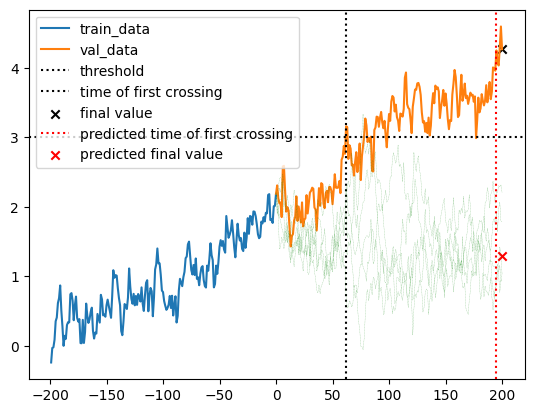

In [6]:
fit_and_evaluate_model(3, 0.01, threshold, future_time, True)

,lag,weight_decay,predicted_crossing_time,predicted_final_value,crossing_error,final_error
0,9,0.057428,75.55,2.713289,13.55,1.552598
1,8,0.194728,112.00,2.149573,50.00,2.116314
2,9,0.262570,82.34,2.677531,20.34,1.588356
3,4,0.092049,197.21,-58.358374,135.21,62.624261
4,10,0.083692,84.78,-14.471968,22.78,18.737856
5,2,0.159218,194.64,1.166430,132.64,3.099457
6,19,0.572063,60.20,2.285242,1.80,1.980645
7,15,1.060199,91.30,2.425488,29.30,1.840399
8,12,0.339350,98.18,1.020597,36.18,3.245290
9,17,2.723468,109.84,2.359948,47.84,1.905939


<Axes: xlabel='crossing_error', ylabel='final_error'>

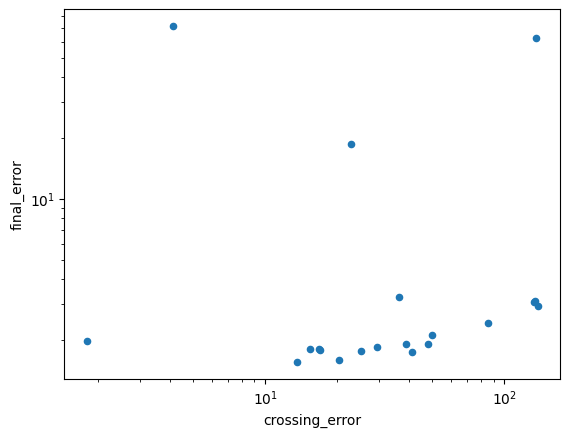

In [7]:
n_models = 20
ks = np.random.randint(20, size=n_models)
weight_decays = np.random.exponential(size=n_models)
results = []
for k, weight_decay in zip(ks, weight_decays):
    hparams = {"lag": k, "weight_decay": weight_decay}
    result = fit_and_evaluate_model(k, weight_decay, threshold, future_time, False)
    results.append({**hparams, **result})
performance_df = pd.DataFrame.from_records(results)
display(performance_df)
performance_df.plot.scatter(x="crossing_error", y="final_error", logy=True, logx=True)

Given this table of performance, rank the models by `crossing_error` and `final_error` (lower values are better), and then compute the max of those ranks to get a final performance measure. That will allow you to rank these models from best to worst.

You can use the plackett-luce model to assign a $p$ to each of these models, but I want you to assign a $p$ to each pair `(lag, weight_decay)`. In other words, let

```
class PredictP(nn.Module):
    def forward(self, lag, weight_decay):
        """Predict p (from the plackett-luce model) given a lag and weight decay"""
        ...
```

be some neural network that predicts the $p$ (from plackett-luce) given a `lag` and `weight_decay`. This neural network will have parameters it uses to predict $p$. Fit those parameters to the data using your gradient descent algorithm for the plackett-luce loss.

Once you've fit `PredictP` to the `performance_df`, you can use it to predict the optimal next choice for `lag` and `weight_decay`.

## Worth Estimation (EstimateWorth) and Prediction (PredictP)

In [8]:
import pandas as pd
import numpy as np
import string
import torch

class EstimateWorth:
    def __init__(self, df):

        """
        Initialize the model with performance df.
        
        Parameters:
        -----------
        df: performance_df
        """
        self.df = df.copy()
        self.rank_df = None
        self.competition_matrix = None
        self.pl_result = None

    def compute_ranks(self):
        """Compute ranks for crossing_error and final_error."""
        self.df["Rank1"] = self.df.crossing_error.rank().astype(int)
        self.df["Rank2"] = self.df.final_error.rank().astype(int)
        self.df["Names"] = list(string.ascii_uppercase[:len(self.df)])
        self.rank_df = self.df[['lag', 'weight_decay', 'Names', 'Rank1', 'Rank2']].copy()
        self.rank_df['Max_Rank'] = np.maximum(self.rank_df.Rank1, self.rank_df.Rank2)
        return self.rank_df

    def build_competition_matrix(self):
        """Build pairwise win-count competition matrix from rank_df."""
        if self.rank_df is None:
            self.compute_ranks()

        models = self.rank_df['Names'].values
        ranks = self.rank_df[['Rank1', 'Rank2']].values
        n_models = len(models)

        comp_matrix = pd.DataFrame(
            data=np.zeros((n_models, n_models), dtype=int),
            index=models,
            columns=models
        )

        for i in range(n_models):
            for j in range(n_models):
                if i != j:
                    wins = np.sum(ranks[i] < ranks[j])
                    comp_matrix.iloc[i, j] = wins

        self.competition_matrix = comp_matrix
        return self.competition_matrix

    def plackett_luce(self, lr=0.01, max_iter=100, verbose=False):
        """Estimate worth parameters using Plackett-Luce model."""
        if self.competition_matrix is None:
            self.build_competition_matrix()

        df = self.competition_matrix
        n = len(df)
        p = torch.ones(n, requires_grad=True, dtype=torch.float64)
        optimizer = torch.optim.Adam([p], lr=lr)

        for iteration in range(max_iter):
            optimizer.zero_grad()
            log_likelihood = 0.0
            for i in range(n):
                for j in range(n):
                    if i != j:
                        w_ij = df.iloc[i, j]
                        log_likelihood += w_ij * (torch.log(p[i]) - torch.log(p[i] + p[j]))
            loss = -log_likelihood
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                p /= torch.prod(p).pow(1.0 / n)
            if verbose and (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration+1}: p = {p.detach().numpy()}")

        result_dict = {label: float(value) for label, value in zip(df.columns, p.detach().numpy())}
        self.pl_result = result_dict
        return result_dict

    def result_with_params(self):
        """Return lag, weight_decay, and Plackett-Luce worth values."""
        if self.rank_df is None:
            self.compute_ranks()
        if self.pl_result is None:
            self.plackett_luce()

        res_df = self.rank_df[['lag', 'weight_decay', 'Names']].copy()
        res_df['Worth'] = res_df['Names'].map(self.pl_result)
        return res_df.sort_values(by="Worth", ascending=False).reset_index(drop=True)

In [9]:
worth = EstimateWorth(performance_df)
worth.result_with_params()

,lag,weight_decay,Names,Worth
0,9,0.057428,A,2.783359
1,9,0.262570,C,2.722262
2,18,2.106842,Q,2.676258
3,18,2.124904,O,2.676258
4,13,0.083892,P,2.676258
5,19,0.572063,G,2.643508
6,13,0.792290,S,2.600211
7,11,0.658788,N,2.326528
8,15,1.060199,H,1.824790
9,19,0.041018,R,0.932213


### Prediction

$$p = a*lag + b*(lag)^2 + c*weight\_decay + d*weight\_decay^2 + e$$  

In [10]:
#PredictP

class PredictP:
    def __init__(self, df, lr=0.01, max_iter=100, seed=42, verbose=False):
        self.lr = lr
        self.max_iter = max_iter
        self.verbose = verbose
        self.seed = seed
        self.params = {}
        self.df = df.copy()
        self.rank_df = None
        self.competition_matrix = None

    def compute_ranks(self):
        """Compute ranks for crossing_error and final_error."""
        self.df["Rank1"] = self.df.crossing_error.rank().astype(int)
        self.df["Rank2"] = self.df.final_error.rank().astype(int)
        self.df["Names"] = list(string.ascii_uppercase[:len(self.df)])
        self.rank_df = self.df[['lag', 'weight_decay', 'Names', 'Rank1', 'Rank2']].copy()
        self.rank_df['Max_Rank'] = np.maximum(self.rank_df.Rank1, self.rank_df.Rank2)
        return self.rank_df

    def build_competition_matrix(self):
        """Build pairwise win-count competition matrix from rank_df."""
        if self.rank_df is None:
            self.compute_ranks()

        models = self.rank_df['Names'].values
        ranks = self.rank_df[['Rank1', 'Rank2']].values
        n_models = len(models)

        comp_matrix = pd.DataFrame(
            data=np.zeros((n_models, n_models), dtype=int),
            index=models,
            columns=models
        )

        for i in range(n_models):
            for j in range(n_models):
                if i != j:
                    wins = np.sum(ranks[i] < ranks[j])  # number of criteria where i beats j
                    comp_matrix.iloc[i, j] = wins

        self.competition_matrix = comp_matrix
        return self.competition_matrix

    def fit(self):
        torch.manual_seed(self.seed)
        self.n = len(self.df)

        # Compute ranks and build competition matrix
        self.compute_ranks()
        comp_matrix_df = self.build_competition_matrix()

        W = torch.tensor(comp_matrix_df.values, dtype=torch.float64)

        # Extract hyperparameters as tensors
        lag = torch.tensor(self.rank_df['lag'].values, dtype=torch.float64)
        weight = torch.tensor(self.rank_df['weight_decay'].values, dtype=torch.float64)

        # Initialize learnable parameters
        a = torch.randn(1, dtype=torch.float64, requires_grad=True)
        b = torch.randn(1, dtype=torch.float64, requires_grad=True)
        c = torch.randn(1, dtype=torch.float64, requires_grad=True)
        d = torch.randn(1, dtype=torch.float64, requires_grad=True)
        e = torch.tensor(0.0, dtype=torch.float64, requires_grad=True)

        params = [a, b, c, d, e]
        optimizer = torch.optim.Adam(params, lr=self.lr)

        for iteration in range(self.max_iter):
            optimizer.zero_grad()

            # Worth function
            p = a * lag + b * lag**2 + c * weight + d * weight**2 + e
            p = torch.exp(p)

            log_likelihood = 0.0
            for i in range(self.n):
                for j in range(self.n):
                    if i != j:
                        log_likelihood += W[i, j] * (torch.log(p[i]) - torch.log(p[i] + p[j]))

            loss = -log_likelihood
            loss.backward()
            optimizer.step()

            if self.verbose and (iteration % 10 == 0 or iteration == self.max_iter - 1):
                print(f"Iteration {iteration+1}: Loss = {loss.item()}")

        # Save learned parameters (in exp scale)
        self.params = {
            'a': np.exp(a.item()),
            'b': np.exp(b.item()),
            'c': np.exp(c.item()),
            'd': np.exp(d.item()),
            'e': np.exp(e.item())
        }

    def predict_p(self, lag_values, weight_values):
        lag_tensor = torch.tensor(lag_values, dtype=torch.float64)
        weight_tensor = torch.tensor(weight_values, dtype=torch.float64)

        p = (self.params['a'] * lag_tensor +
             self.params['b'] * lag_tensor**2 +
             self.params['c'] * weight_tensor +
             self.params['d'] * weight_tensor**2 +
             self.params['e'])

        return p.detach().numpy()

    def get_params(self):
        return self.params

    def get_competition_matrix(self):
        return self.competition_matrix.copy()

In [11]:
model = PredictP(performance_df, lr=0.01, max_iter=100, verbose=True)
model.fit()

model.get_params()
model.predict_p([9, 15], [0.01, 0.035])

Iteration 1: Loss = 2116.079375425424
Iteration 11: Loss = 642.1855451858983
Iteration 21: Loss = 247.30282765866352
Iteration 31: Loss = 267.36851774254194
Iteration 41: Loss = 222.12682011733506
Iteration 51: Loss = 216.43621192624238
Iteration 61: Loss = 216.78207849801265
Iteration 71: Loss = 214.7103985770662
Iteration 81: Loss = 213.20166647164956
Iteration 91: Loss = 213.09560403848923
Iteration 100: Loss = 212.70882757335002


array([ 93.2597076 , 244.18792205])